# Step8 演習04 バックプロバゲーション
---

ニューラルネットワークでマルチ分類問題を解くためには、各ニューロンを結合する重みやバイアスといったパラメータを求める必要があります。

これらのパラメータはscikit-learn の MLPClassifier のようなライブラリを用いれば求めることができました。

これらのライブラリではバックプロバゲーションを使って係数を求めます。この演習では、バックプロバゲーションを実際に実装してみましょう。


**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での使用は避けてください。

**本演習の目的**
- ニューラルネットワークのモデルを構築し、フォワードプロパゲーション・バックプロパゲーションの実装をする。

## ライブラリのインポート

まずはじめに、利用するライブラリのインポートを行います。

- [NumPy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [Matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [scikit-learn](http://scikit-learn.org/stable/index.html) Pythonのオープンソース機械学習ライブラリの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番に**順次実行してください。

** 注意： **初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 線形分離不可能なデータセット

線形分離不可能なデータセットの例としてXNORを使います。

<table style="width:30%">

	<thead>
	<tr>
		<th >入力$X_1$</th>
		<th >入力$X_2$</th>
		<th >出力$y$</th>
	</tr>
	</thead>

  <tr>
    <td>0</td>
    <td> 0 </td> 
    <td> 1 </td> 
  </tr>
  
    <tr>
    <td>1</td>
    <td> 1 </td> 
    <td> 1 </td> 
  </tr>
  
    <tr>
    <td>0</td>
    <td> 1 </td> 
    <td> 0 </td> 
  </tr>
 
     <tr>
    <td>1</td>
    <td> 0 </td> 
    <td> 0 </td> 
  </tr>
  
</table>

In [2]:
X = np.array([[0, 0], [1, 1], [1, 0], [0, 1]])
y = np.array([[1], [1], [0], [0]])

## データの視覚化

下記の分類問題を解くニューラルネットワークを実装することを目標にします。

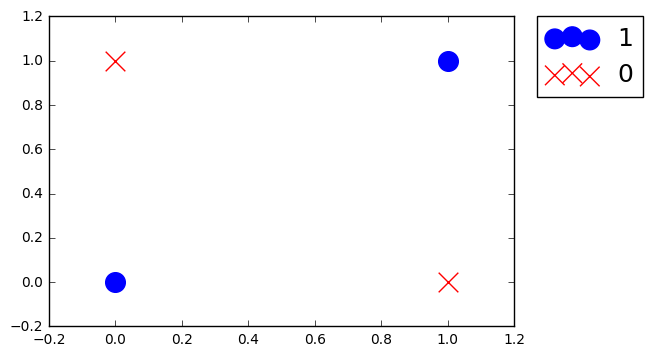

In [3]:
plt.scatter(X[0][0], X[0][1], s=200, color='blue',  marker='o', label='1')
plt.scatter(X[1][0], X[1][1], s=200, color='blue', marker='o')
plt.scatter(X[2][0], X[2][1], s=200, color='red', marker='x',  label='0')
plt.scatter(X[3][0], X[3][1], s=200, color='red', marker='x')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()

## フォワードプロバゲーションの実装準備

バックプロバゲーションは、フォワードプロバゲーションで得られた出力と正解との誤差を逆方向に伝播する処理なので、まずフォワードプロパゲーションを実装して正解との誤差を求めます。

<div align="center"  style="width:75%">
<img src="./dataStep8/forward_prop.png"></div>

上の画像のようなニューラルネットワークのモデルを構築します。

各層のニューロンの数は以下のようになります。

- 入力層のニューロン数 ２個
- 隠れ層のニューロン数 ２個
- 出力層のニューロン数 １個

In [4]:
input_size = 2
hidden_size = 2
output_size = 1

### パラメータの初期化

図から、各パラメータのシェイプが分かります。W1は２行２列、b1は１行２列、W2は２行１列、b2は１行１列になります。

パラメータの配列のシェイプは各層に配置するニューロンの数に依存します。

各層に配置するニューロンの数が変化しても対応できるようにしておくと便利です。

下記のコードは、各パラメータに設定する値（初期値）を乱数で与えます。

In [5]:
W1 = np.random.randn(input_size,hidden_size)
b1 = np.zeros((1, hidden_size))

W2 = np.random.randn(hidden_size,output_size)
b2 = np.zeros((1, output_size))

各パラメータのシェイプと値を確認してみましょう。

In [6]:
print('W1:', W1.shape)
print('b1:', b1.shape)
print('W2:', W2.shape)
print('b2:', b2.shape)
print('W1:', W1)
print('b1:', b1)
print('W2:', W2)
print('b2:', b2)

W1: (2, 2)
b1: (1, 2)
W2: (2, 1)
b2: (1, 1)
W1: [[-0.90251456  0.44799945]
 [ 1.06760317  0.24093758]]
b1: [[0. 0.]]
W2: [[-0.18772043]
 [ 0.59525192]]
b2: [[0.]]


### 活性化関数

フォワードプロパゲーションで利用する活性化関数を下記のように実装します。

In [7]:
# シグモイド関数
def sigmoid(x):
    return 1/(1 + np.exp(-x))

# relu関数
def relu(x):
     return np.maximum(0, x)

## フォワードプロバゲーションの実装

隠れ層の活性化関数g1()はrelu関数、出力層の活性化関数は確率解釈ができるようにsigmoid関数を用いることにして、図の通りフォワードプロパゲーションを実装します。

In [8]:
#　フォワードプロパゲーション
layer1_z = np.dot(X, W1) + b1 
layer1_a = relu(layer1_z)  #relu activation

layer2_z = np.dot(layer1_a, W2) + b2
layer2_a = sigmoid(layer2_z)  # Sigmoid

output = layer2_a  #layer2_a is the output

## バックプロバゲーションの実装
下図のバックプロバゲーションを実装してみましょう。


<div align="center"  style="width:75%">
<img src="./dataStep8/back_prop.png"></div>

### 活性化関数の微分

バックプロバーゲーションを行うには、活性関数の微分が必要になるので、sigimoid関数とrelu関数の微分を実装します。

** 【課題７】 ** シグモイド関数の微分出力を返す関数 sigmoid_derivative(x) を実装してください。

**Note:**
シグモイド関数の微分の定義です。

$$\sigma'{(x)}=\sigma{(x)}(1-\sigma{(x)})$$

In [9]:
#Coursemale-02 Step8 QuestionNumber7 92eb9778f949cabe3092ac9dd7cee0a8
def sigmoid_derivative(x):
###############ここを穴埋めしてください###############
    y = sigmoid(x)*(1 - sigmoid(x))
######################################################
    return y

** 左上の保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [10]:
%%bash
./validation_client.py male-02 8 7 Step8_04.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



ReLU関数の微分出力を返す関数 relu_derivative(x) として定義しました。

**Note：**ReLU関数の微分の定義です。

$$
  relu\_derivative(x) = \left\{ \begin{array}{ll}
    1　(x>0) \\
    0　(x≦0)
  \end{array} \right.
$$

ReLU関数の微分は入力が正のときは１出力し、入力が負のときゼロを出力します。

In [11]:
def relu_derivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

シグモイド関数とシグモイド関数の微分の出力結果をプロットしてみます。

下のセルを実行してください。

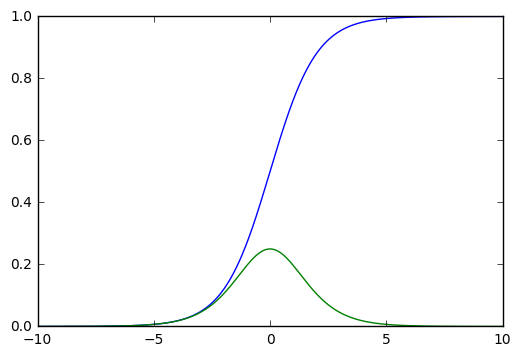

In [12]:
# シグモイド関数
x = np.arange(-10,10,0.01) 
y_ = sigmoid(x)
plt.plot(x, y_) 

# シグモイド関数の微分
x = np.arange(-10,10,0.01) 
y_derivative = sigmoid_derivative(x)
plt.plot(x, y_derivative) 

plt.show() 

ReLU関数とReLU関数の微分の出力結果をプロットしてみます。

下のセルを実行してください。

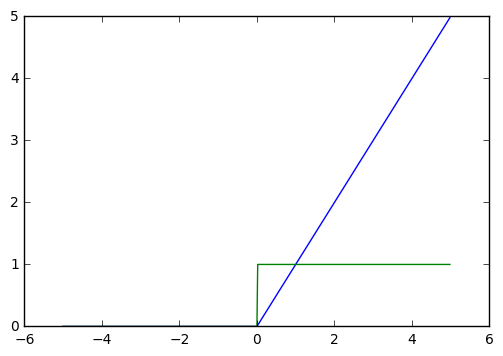

In [13]:
# relu関数
x = np.arange(-5, 5, 0.02) 
y_ = relu(x)
plt.plot(x, y_) 

# relu関数の微分
x = np.arange(-5, 5, 0.02) 
y_derivative = relu_derivative(x)
x = np.arange(-5, 5, 0.02) 
plt.plot(x, y_derivative) 

plt.show() 

## バックプロパゲーションの実装

#### パラメータを更新する量（変化量）の算出
フォワードブロパゲーションを実行した結果得られた出力（output）と、期待される値（正解 y）との誤差を計算し、それを逆伝播することで、次に用いるW2、b2、W1、b2をどれだけ変化（調整）すべきか算出します。

**【課題８】** 逆伝播を行う関数 back_propagation(X, y, W2, output, layer2_z, layer1_a, layer1_z) を実装してください。

戻り値は、目的関数のパラメータに関する勾配 $w_1,b_1,w_2,b_2$ とします。

In [14]:
#Coursemale-02 Step8 QuestionNumber8 9c295e7bb92680c8bf12fc4f1b05f600
def back_propagation(X, y, W2, output, layer2_z, layer1_a, layer1_z):
###############ここを穴埋めしてください###############
    delta2 = (output - y) * sigmoid_derivative(layer2_z)
    delta_W2 = np.dot(layer1_a.T, delta2) 
    delta_b2 = np.sum(delta2, axis=0 ,keepdims=True)

    delta1 = np.dot(delta2, W2.T) * relu_derivative(layer1_z)
    delta_W1 = np.dot(X.T, delta1) 
    delta_b1 = np.sum(delta1, axis=0 ,keepdims=True)
######################################################
    return delta_W2, delta_b2, delta_W1, delta_b1

** 左上の保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [15]:
%%bash
./validation_client.py male-02 8 8 Step8_04.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



In [16]:
delta_W2, delta_b2, delta_W1, delta_b1 = back_propagation(X, y, W2, output, layer2_z, layer1_a, layer1_z)

In [17]:
print(delta_W2)
print(delta_b2)
print(delta_W1)
print(delta_b1)

[[0.11336111]
 [0.02401314]]
[[0.03740026]]
[[ 0.01840068  0.02444097]
 [-0.00437739  0.01388047]]
[[-0.00437739  0.09666906]]


## パラメータの更新

学習率（learning_rate）を設定し、この値を先ほど求めたdelta_W1、delta_b1,
delta_W2、delta_b2に掛けた分だけ各パラメータの量を変化させます。

In [18]:
learning_rate = 0.01

**【課題９】** パラメータの更新を行う関数 update_parameters(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate) を実装してください。

戻り値は、パラメータ $W_1,b_1,W_2,b_2$ とします。

In [19]:
#Coursemale-02 Step8 QuestionNumber9 61a3cc9e875960f7bae3964877e2c06c
def update_parameters(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate):
###############ここを穴埋めしてください###############
    W1 = W1 - learning_rate * delta_W1
    b1 = b1 - learning_rate * delta_b1    
    W2 = W2 - learning_rate * delta_W2
    b2 = b2 - learning_rate * delta_b2
######################################################
    return W1, b1, W2, b2

** 左上の保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [20]:
%%bash
./validation_client.py male-02 8 9 Step8_04.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



In [21]:
W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, delta_W1, delta_b1, delta_W2, delta_b2, learning_rate)

In [22]:
print(W1)
print(b1)
print(W2)
print(b2)

[[-0.90269857  0.44775504]
 [ 1.06764695  0.24079877]]
[[ 4.37738814e-05 -9.66690636e-04]]
[[-0.18885405]
 [ 0.59501179]]
[[-0.000374]]


このようにして求めた新しいW1、b1、W2、b2を用いて、再度フォワードブロパゲーションを実行します。

その結果得られた出力をバックワードプロパゲーションを用いて、新たなW1、b1、W2、b2を再計算します。

そして、再度フォワードブロパゲーションを実行して。。。というように、このプロセスを何度も繰り返し、目的関数の値が十分小さくなる（変化しなくなる）まで繰り返します。

## ニューロラルネットワークの学習
上記のコードを全てまとめると、以下のようになります。

すべてのトレーニングデータを学習に使う回数をエポックと呼びます。エポックを調整し、十分学習曲線が落ち着くまで学習させます。

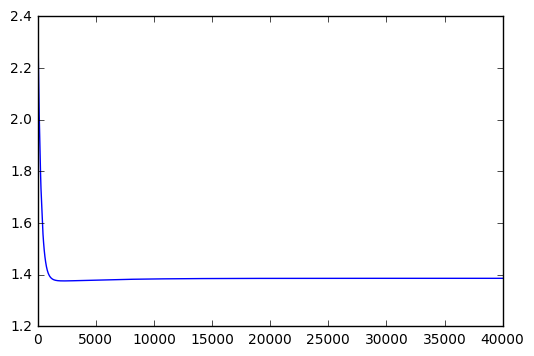

In [23]:
X = np.array([[0, 0], [1, 1], [1, 0], [0, 1]])
y = np.array([[1], [1], [0], [0]])

# ニューラルネットワークの構造を決める
input_size = 2
hidden_size = 2
output_size = 1

# 初期値設定（乱数で与える）
W1 = np.random.randn(input_size,hidden_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size,output_size)
b2 = np.zeros((1, output_size))

#　学習率
learning_rate = 0.01

# setup parameters for batch operation
epochs = 40000

cost = []
for _ in range(epochs):
    #　フォワードプロパゲーション
    layer1_z = np.dot(X, W1) + b1 
    layer1_a = relu(layer1_z)          # relu activation

    layer2_z = np.dot(layer1_a, W2) + b2
    layer2_a = sigmoid(layer2_z)       # Sigmoid

    output = layer2_a                  # layer2_a is the output

    # Compute cost (Softmax Cross Entropy)
    cost.append(-np.sum(y * np.log(output)))

    #　バックプロパゲーション
    delta2 = (output - y)*sigmoid_derivative(layer2_z)
    delta_W2 = np.dot(layer1_a.T, delta2) 
    delta_b2 = np.sum(delta2, axis=0 ,keepdims=True)

    delta1 = np.dot(delta2, W2.T) * relu_derivative(layer1_z)
    delta_W1 = np.dot(X.T, delta1) 
    delta_b1 = np.sum(delta1, axis=0 ,keepdims=True)

    # Update Parameters
    W2 = W2 - learning_rate * delta_W2
    b2 = b2 - learning_rate * delta_b2
    W1 = W1 - learning_rate * delta_W1
    b1 = b1 - learning_rate * delta_b1

plt.plot(cost)
plt.show()

#### 学習結果を確認する
正しく学習できたかどうか確認してみましょう。学習して入手したパラメータを使ってフォワードブロパゲーションを実行し、期待通りの学習ができているかどうか確認してみましょう。

In [24]:
X = np.array([[0, 0], [1, 1], [1, 0], [0, 1]])

#　フォワードプロパゲーション
layer1_z = np.dot(X, W1) + b1 
layer1_a = relu(layer1_z)          # relu activation

layer2_z = np.dot(layer1_a, W2) + b2
layer2_a = sigmoid(layer2_z)       # Sigmoid

output = layer2_a                  # layer2_a is the output

print(output)

[[0.5000051 ]
 [0.499996  ]
 [0.50000202]
 [0.49999907]]


最初の２つの値が１に近く、最後の２つの値が０に近ければ学習に成功しています。

### （発展課題）マルチクラス問題を解く

ニューラルネットワークの最終層にsoftmaxを用いたニューラルネットワークを使ってマルチクラス分類問題を解いてみましょう。

目的関数にクロスエントロピーを、最終層にsoftmaxを用いた場合、delta2は出力（output）と正解(y)との誤差「output - y」だけになります。

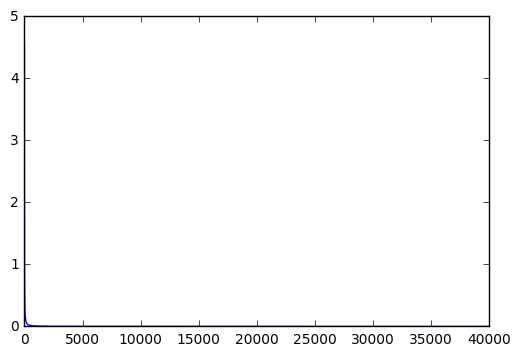

In [25]:
X = np.array([[0, 0], [1, 1], [1, 0], [0, 1]])
y = np.array([[1, 0], [1, 0], [0, 1], [0, 1]])

def softmax(x):
    c = np.max(x)
    exp_x = np.exp(x - c)
    y = exp_x / np.sum(exp_x, axis=1, keepdims=True) 
    return y

# ニューラルネットワークの構造を決める
input_size = 2
hidden_size = 10
output_size = 2

# 初期値設定（乱数で与える）
W1 = np.random.randn(input_size,hidden_size)
b1 = np.zeros((1, hidden_size))

W2 = np.random.randn(hidden_size,output_size)
b2 = np.zeros((1, output_size))

#　学習率
learning_rate = 0.1

# setup parameters for batch operation
epochs = 40000

cost = []
for _ in range(epochs):
    #　フォワードプロパゲーション
    layer1_z = np.dot(X, W1) + b1 
    layer1_a = relu(layer1_z)          # relu activation

    layer2_z = np.dot(layer1_a, W2) + b2
    layer2_a = softmax(layer2_z)       # softmax

    output = layer2_a                  # layer2_a is the output

    # Compute cost (Softmax Cross Entropy)
    cost.append(-np.sum(y * np.log(output)))

    #　バックプロパゲーション
    delta2 = (output - y)
    delta_W2 = np.dot(layer1_a.T, delta2) 
    delta_b2 = np.sum(delta2, axis=0 ,keepdims=True)

    delta1 = np.dot(delta2, W2.T) * relu_derivative(layer1_z)
    delta_W1 = np.dot(X.T, delta1) 
    delta_b1 = np.sum(delta1, axis=0 ,keepdims=True)

    # Update Parameters
    W2 = W2 - learning_rate * delta_W2
    b2 = b2 - learning_rate * delta_b2
    W1 = W1 - learning_rate * delta_W1
    b1 = b1 - learning_rate * delta_b1

plt.plot(cost)
plt.show()

#### フォワードプロパゲーションで学習結果を確認してみよう

In [26]:
X = np.array([[0, 0], [1, 1], [1, 0], [0, 1]])

#　フォワードプロパゲーション
layer1_z = np.dot(X, W1) + b1 
layer1_a = relu(layer1_z)          # relu activation

layer2_z = np.dot(layer1_a, W2) + b2
layer2_a = softmax(layer2_z)       # Softmax

output = layer2_a                  # layer2_a is the output

print(output)

[[9.99957084e-01 4.29157518e-05]
 [9.99993024e-01 6.97622258e-06]
 [1.38160336e-05 9.99986184e-01]
 [1.14683133e-05 9.99988532e-01]]


#### 学習結果を可視化してみましょう

/opt/conda/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/opt/conda/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-1.0, 1.9800000000000026)

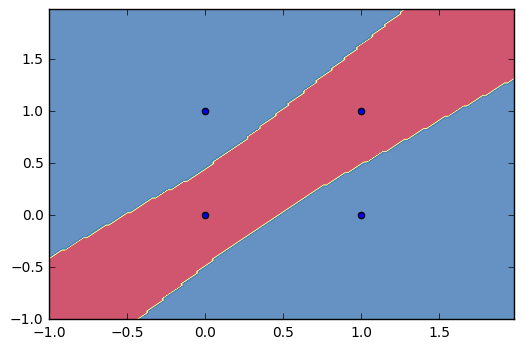

In [27]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

このニューラルネットワークを利用すれば、実際にMNISTの画像の分類問題を解くことができます。発展課題としてチャレンジしてみてください。